# Example from Pytorch-Tabnet

In [23]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

# Download census-income dataset

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [5]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

# Load data and split

In [6]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [7]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [8]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Network parameters

In [9]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cuda


# Training

In [10]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [11]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [12]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -0.17668 |  -0.32298 |   1.7       
| 2     | -0.13827 |  -0.17600 |   3.2       
| 3     | -0.12958 |  -0.22527 |   4.6       
| 4     | -0.12434 |  -0.13849 |   6.1       
| 5     | -0.12272 |  -0.14207 |   7.4       
| 6     | -0.12037 |  -0.12945 |   8.9       
| 7     | -0.11798 |  -0.12142 |   10.3      
| 8     | -0.11576 |  -0.11550 |   11.7      
| 9     | -0.11586 |  -0.11345 |   13.1      
| 10    | -0.11330 |  -0.11597 |   14.5      
| 11    | -0.11157 |  -0.10801 |   15.9      
| 12    | -0.11081 |  -0.10700 |   17.4      
| 13    | -0.10818 |  -0.11060 |   18.7      
| 14    | -0.10811 |  -0.11288 |   20.1      
| 15    | -0.10694 |  -0.10262 |   21.5      
| 16    | -0.10553 |  -0.10562 |   22.8      
| 17    | -0.10623 |  -0.10134 |   24.3      
| 18    | -0.10416 |  -0.10369 |   25.6      
| 19    | -0

In [13]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")

BEST VALID SCORE FOR census-income : 0.0953194797039032
FINAL TEST SCORE FOR census-income : 0.09953681463189108


# Global explainability : feat importance summing to 1

In [14]:
clf.feature_importances_

array([0.11222507, 0.01050163, 0.00939182, 0.14140154, 0.01245154,
       0.08380866, 0.15639717, 0.04467439, 0.00165761, 0.00099142,
       0.25578231, 0.00118283, 0.03724031, 0.1322937 ])

# Local explainability and masks

In [15]:
explain_matrix, masks = clf.explain(X_test)

In [22]:
explain_matrix

array([[0.47071332, 0.        , 0.        , ..., 0.        , 0.        ,
        0.23847537],
       [0.12180714, 0.        , 0.        , ..., 0.        , 0.0780478 ,
        0.        ],
       [0.        , 0.00252125, 0.        , ..., 0.        , 0.00144717,
        0.        ],
       ...,
       [0.11831468, 0.01298389, 0.0417505 , ..., 0.        , 0.14293262,
        0.        ],
       [0.02146184, 0.        , 0.        , ..., 0.        , 0.10680711,
        0.        ],
       [0.00117433, 0.        , 0.        , ..., 0.12289415, 0.00196807,
        0.        ]])

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

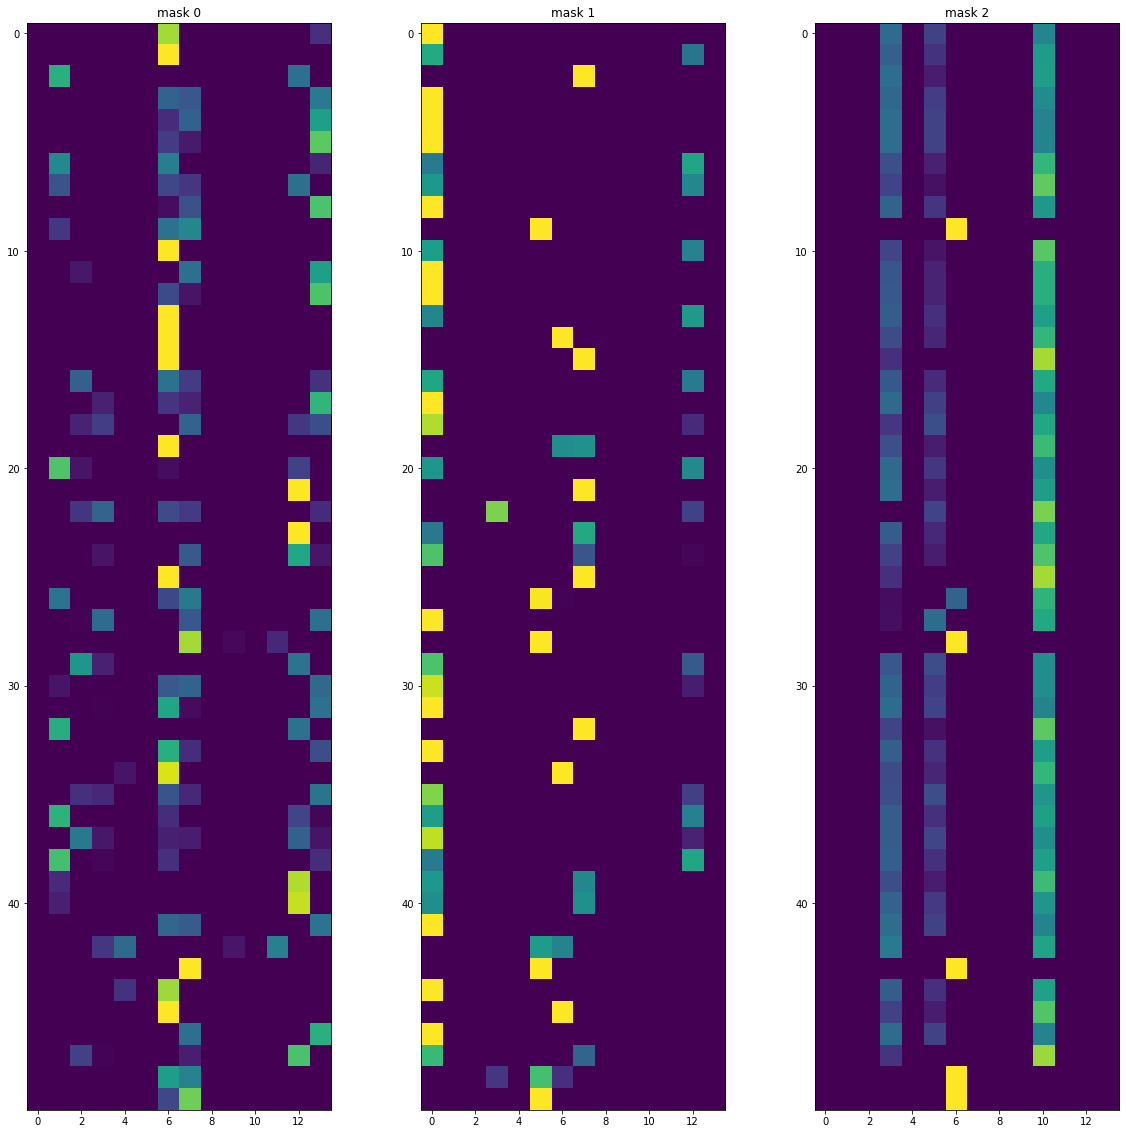

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [ ]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

In [ ]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)